# Model Tuning

On a classification problem of bot or no-bot, we shall apply most optimal model i.e Decision Tree. It's time to see what are best hyperparemeter we may use for it

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [5]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# for evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,sklearn, matplotlib, seaborn

Software versions
Python 3.6.3 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.4.0
OS Windows 10 10.0.16299 SP0
pandas 0.23.4
numpy 1.16.2
sklearn 0.20.3
matplotlib 2.1.0
seaborn 0.9.0
Fri Sep 27 20:56:19 2019 W. Europe Daylight Time

# 2)-Loading datasets 

In [8]:
df =pd.read_csv('clickdata.csv')
df.shape

(59782, 8)

In [9]:
# clean up different types of missing values
df = df.replace(np.nan, '', regex=True)
df = df.replace('Unknown', '', regex=True)

In [10]:
df.isnull().sum()

epoch_ms                       0
session_id                     0
country_by_ip_address          0
region_by_ip_address           0
url_without_parameters         0
referrer_without_parameters    0
visitor_recognition_type       0
ua_agent_class                 0
dtype: int64

In [11]:
print(df.duplicated().sum())

0


In [12]:
df.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot Mobile


### 2a)- Encoding

In [13]:
df = df[~df['ua_agent_class'].isin(['Special'])]

In [14]:
df.ua_agent_class.unique()

array(['Robot', 'Browser', 'Robot Mobile', 'Browser Webview', 'Hacker',
       'Mobile App', 'Cloud Application'], dtype=object)

In [15]:
df['category'] = df.ua_agent_class.map({'Robot':'NHT', 'Robot Mobile':'NHT','Browser':'HT', 'Browser Webview':'HT','Hacker':'HT','Mobile App':'HT','Cloud Application':'HT'})

In [16]:
df.category.unique()

array(['NHT', 'HT'], dtype=object)

In [17]:
df.category.value_counts()

HT     38497
NHT    21141
Name: category, dtype: int64

In [18]:
df.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,category
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,NHT
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,NHT
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,HT
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,NHT
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot Mobile,NHT


In [19]:
# create dataframe for feature of interest
df_foi=df[['category','visitor_recognition_type','country_by_ip_address','region_by_ip_address']]

### 2b)- creating target and independant variables

In [20]:
# select a few columns and transform them into features
X = pd.get_dummies(data=df[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']], drop_first=True)

In [21]:
y = pd.get_dummies(df.category, prefix='category').iloc[:,1:]

In [22]:
print(X.shape)
print(y.shape)

(59638, 293)
(59638, 1)


### 3c)-data split 

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2019)

# 4)- Model

### 4.1)- Fit the model

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
y_pred = dt.predict(X_test)

### 4.2)- Evaulate model

**Null accuracy**

In [26]:
# calculate the percentage of ones
y_test.mean()

category_NHT    0.3527
dtype: float64

In [27]:
# calculate the percentage of zeros
1 - y_test.mean()

category_NHT    0.6473
dtype: float64

This score shows accuracy that could be achieved by always predicting the most frequent class

**Accuracy**

In [28]:
print(accuracy_score(y_test, y_pred))

0.9810529845741114


Our decicion tree model performs way better than null accuracy

#### ROC_AUC

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems

In [29]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9839041307702635

# 5)- Model Tuning

- max_depth
- min_samples_split
- min_samples_leaf
- max_features

### 5.1)-max_depth

The first parameter to tune is max_depth. This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test auc scores.

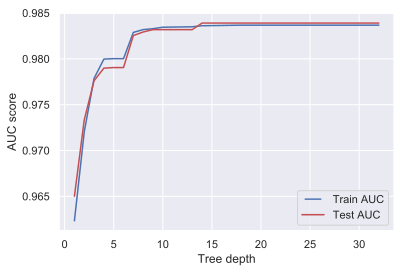

In [30]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model is consistent all over. We have no over-fitting issue

### 5.2)-min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

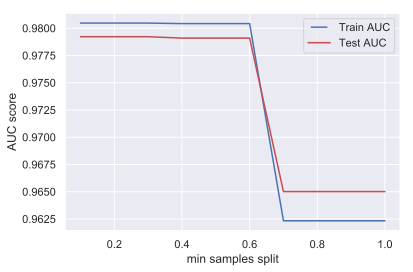

In [31]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

We can clearly see that when we consider 100% of the samples at each node, the model cannot learn enough about the data. This is an underfitting for higher value. For a better model, we shall keep points where we see no under-fitting

### 5.3)-min_samples_leaf

min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

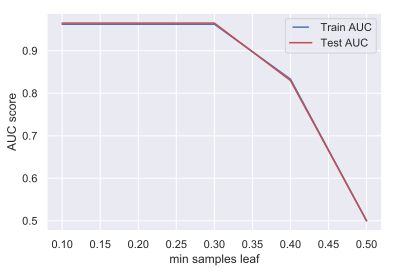

In [32]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

This shows that our results are consistent. There is no over fitting

### 5.4)-max_features

max_features represents the number of features to consider when looking for the best split

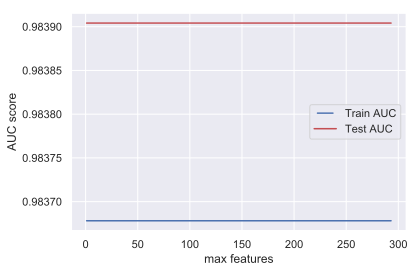

In [33]:
# use merged dataframe 

df_new=X
df_new['category']=y

max_features = list(range(1,df_new.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

Very consistent again. Model learns slightly poor though. So, there is hint of under-fitting. It’s unexpected to get underfitting for all values of max_features. However, according to sklearn documentation for decision tree, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

# 6)-RandomizedSearchCV

In [34]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [35]:
# setup parameters

param_dist = {"criterion": ["gini", "entropy"],
              "min_samples_split": randint(20, 40),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "max_leaf_nodes": randint(2, 20)}

In [36]:
# instantiate a decision tree
tree= DecisionTreeClassifier()

# instantiate RandomizedSearchCV

tree_cv=RandomizedSearchCV(tree, param_dist,scoring='roc_auc', cv=5)

In [37]:
# fit on model
tree_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'criterion': ['gini', 'entropy'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002229BE0D940>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002229BA925C0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002229BE15860>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002229BC916D8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [38]:
# print tuned parameters and roc score

print("Tuned Decision Tree Parameters:{}".format(tree_cv.best_params_))
print("Best Score:{}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 17, 'max_leaf_nodes': 18, 'min_samples_leaf': 16, 'min_samples_split': 38}
Best Score:0.9905618782190689


In [39]:
tree_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=17,
            max_features=None, max_leaf_nodes=18,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=38,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
y_pred_randomsearch=tree_cv.predict(X_test)

In [41]:
y_pred_randomsearch[:5]

array([1, 0, 1, 0, 0], dtype=uint8)

In [42]:
y_pred_class_randomsearch=tree_cv.predict_proba(X_test)[0:10, :]

In [43]:
y_pred_class_randomsearch[:5]

array([[3.26785498e-02, 9.67321450e-01],
       [9.99630938e-01, 3.69062055e-04],
       [3.26785498e-02, 9.67321450e-01],
       [9.99630938e-01, 3.69062055e-04],
       [9.99630938e-01, 3.69062055e-04]])

In [44]:
print(accuracy_score(y_test, y_pred_randomsearch))

0.9799631120053656


In [45]:
print(roc_auc_score(y_test, y_pred_randomsearch))

0.9827377243944976


**This is most optimal roc_auc_score generated from decision tree model**

In [46]:
print(classification_report(y_test, y_pred_randomsearch))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7721
           1       0.95      0.99      0.97      4207

   micro avg       0.98      0.98      0.98     11928
   macro avg       0.97      0.98      0.98     11928
weighted avg       0.98      0.98      0.98     11928



# 7) Submission

In [47]:
# give name to index
X_test.index.name
X_test.index.name = 'Index_ID'

In [48]:
X_test[:5]

,country_by_ip_address_AL,country_by_ip_address_AM,country_by_ip_address_AR,country_by_ip_address_AT,country_by_ip_address_AU,country_by_ip_address_BD,country_by_ip_address_BE,country_by_ip_address_BG,country_by_ip_address_BO,country_by_ip_address_BR,...,region_by_ip_address_WLG,region_by_ip_address_WLX,region_by_ip_address_WNA,region_by_ip_address_WP,region_by_ip_address_ZE,region_by_ip_address_ZG,region_by_ip_address_ZH,region_by_ip_address_ZP,visitor_recognition_type_LOGGEDIN,visitor_recognition_type_RECOGNIZED
Index_ID,,,,,,,,,,,,,,,,,,,,,
21252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29343,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
36259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
index_id=X_test.index

In [50]:
y_pred_randomsearch[:5]

array([1, 0, 1, 0, 0], dtype=uint8)

In [51]:
pred_proba=tree_cv.predict_proba(X_test)[:, 1]
pred_proba[:5]

array([9.67321450e-01, 3.69062055e-04, 9.67321450e-01, 3.69062055e-04,
       3.69062055e-04])

In [52]:
submission = pd.DataFrame({
        "Id": index_id,
        "bot_or_not ": y_pred_randomsearch,
        "Bot_Probability":pred_proba
    })
submission.to_csv('submission.csv', index=False)

In [53]:
df_submit =pd.read_csv('submission.csv')
df_submit.head()

,Id,bot_or_not,Bot_Probability
0,21252,1,0.967321
1,29343,0,0.000369
2,43329,1,0.967321
3,23237,0,0.000369
4,36259,0,0.000369
